In [1]:
# Gerekli kütüphaneleri içe aktarıyoruz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# TensorFlow ve Keras kütüphaneleri
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("Kütüphaneler başarıyla yüklendi.")

# Kaggle'daki veri seti yolları
# Veri seti genellikle bir zip dosyası olarak gelir, önce onu açalım.
# Eğer dosyalar zaten açıksa bu adımı atlayabilirsiniz.

# train.zip ve test1.zip dosyalarını açma
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as z:
    z.extractall('.')

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as z:
    z.extractall('.')

# Dosya yollarını ve etiketleri hazırlama
TRAIN_DIR = 'train/'
filenames = os.listdir(TRAIN_DIR)
labels = []
for filename in filenames:
    label = filename.split('.')[0] # Dosya adı 'cat.1.jpg' veya 'dog.1.jpg' şeklindedir
    if label == 'cat':
        labels.append('cat')
    else:
        labels.append('dog')

# Dosya adları ve etiketlerden bir DataFrame oluşturuyoruz.
# Bu yapı, veriyi yönetmeyi çok kolaylaştırır.
df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

# Oluşturduğumuz DataFrame'in ilk 5 satırına bakalım
print(df.head())
print("\nVeri setindeki toplam resim sayısı:", len(df))
print("\nSınıflara göre resim sayıları:\n", df['label'].value_counts())

2025-09-23 17:45:11.078032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758649511.334912      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758649511.407681      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Kütüphaneler başarıyla yüklendi.
        filename label
0   dog.2564.jpg   dog
1   dog.5030.jpg   dog
2  dog.10586.jpg   dog
3   dog.3803.jpg   dog
4  dog.11455.jpg   dog

Veri setindeki toplam resim sayısı: 25000

Sınıflara göre resim sayıları:
 label
dog    12500
cat    12500
Name: count, dtype: int64


In [2]:
# DataFrame'i eğitim (%80) ve doğrulama (%20) olarak ikiye ayırıyoruz
train_df, validation_df = train_test_split(df, test_size=0.20, random_state=42)

# Eğitim setindeki veriyi yeniden dengelemek (eğer dengesiz ise) ve
# boyutunu kontrol etmek için boyutlarını yeniden ayarlıyoruz
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

# Görüntü boyutları ve diğer parametreler
IMG_WIDTH = 150
IMG_HEIGHT = 150
IMG_CHANNELS = 3 # Renkli resimler için 3 (RGB)
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32

# Veri Çoğaltma (Data Augmentation) ile ImageDataGenerator oluşturma
# Bu işlem, eğitim verilerini yapay olarak artırarak modelin genelleme yeteneğini geliştirir.
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Piksel değerlerini 0-1 arasına ölçekle
    rotation_range=40,          # Resmi rastgele 40 dereceye kadar döndür
    width_shift_range=0.2,      # Resmi yatayda %20'ye kadar kaydır
    height_shift_range=0.2,     # Resmi dikeyde %20'ye kadar kaydır
    shear_range=0.2,            # Resmi eğ/bük
    zoom_range=0.2,             # Resme %20'ye kadar zoom yap
    horizontal_flip=True,       # Resmi yatayda rastgele çevir
    fill_mode='nearest'         # Oluşan boş pikselleri en yakın pikselle doldur
)

# Doğrulama verisi için çoğaltma yapmıyoruz, sadece ölçekleme yapıyoruz!
# Çünkü modelin performansını orijinal resimler üzerinde ölçmek isteriz.
validation_datagen = ImageDataGenerator(rescale=1./255)

# DataFrame'den akan veri üreteçleri oluşturuyoruz
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='binary', # İki sınıfımız var: kedi ve köpek
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [3]:
# Model mimarisini oluşturuyoruz
model = Sequential([
    # 1. Evrişim ve Havuzlama Bloğu
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)),
    MaxPooling2D((2, 2)),
    
    # 2. Evrişim ve Havuzlama Bloğu
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # 3. Evrişim ve Havuzlama Bloğu
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Özellik haritalarını tek boyutlu bir vektöre düzleştirme
    Flatten(),
    
    # Sınıflandırma için tam bağlantılı katman
    Dense(512, activation='relu'),
    
    # Overfitting'i önlemek için Dropout katmanı
    Dropout(0.5),
    
    # Çıkış katmanı (1 nöron, çünkü kedi mi değil mi diye soruyoruz - binary)
    # Sigmoid aktivasyonu, sonucu 0 ile 1 arasında bir olasılık değerine dönüştürür.
    Dense(1, activation='sigmoid')
])

# Modeli derliyoruz
model.compile(optimizer='adam',
              loss='binary_crossentropy', # İkili sınıflandırma için en uygun kayıp fonksiyonu
              metrics=['accuracy'])

# Modelin mimarisini özet olarak görelim
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758649538.101448      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758649538.102177      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Modeli eğitiyoruz
# Bu işlem GPU'nuzun hızına bağlı olarak zaman alabilir. Kaggle'da GPU'yu aktif etmeyi unutmayın!
EPOCHS = 15 # Veri setinin tamamının üzerinden kaç kez geçileceği

history = model.fit(
    train_generator,
    steps_per_epoch=train_df.shape[0] // BATCH_SIZE, # Bir epoch'ta kaç adım atılacağı
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_df.shape[0] // BATCH_SIZE # Doğrulama için kaç adım atılacağı
)

# Eğitilen modeli daha sonra kullanmak üzere kaydedebilirsiniz
# model.save('cat_dog_classifier.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1758649542.306460      63 service.cc:148] XLA service 0x7b41b0005000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758649542.307773      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758649542.307798      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758649542.758230      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/625 ━━━━━━━━━━━━━━━━━━━━ 1:11:56 7s/step - accuracy: 0.5625 - loss: 0.6949

I0000 00:00:1758649546.788562      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 185ms/step - accuracy: 0.5643 - loss: 0.6860 - val_accuracy: 0.6721 - val_loss: 0.6105
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 182ms/step - accuracy: 0.6571 - loss: 0.6217 - val_accuracy: 0.7169 - val_loss: 0.5602
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 183ms/step - accuracy: 0.6918 - loss: 0.5839 - val_accuracy: 0.7370 - val_loss: 0.5168
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 181ms/step - accuracy: 0.7187 - loss: 0.5574 - val_accuracy: 0.7246 - val_loss: 0.5637
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 182ms/step - accuracy: 0.7256 - loss: 0.5439 - val_accuracy: 0.7732 - val_loss: 0.4732
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 182ms/step - accuracy: 0.7365 - loss: 0.5253 - val_accuracy: 0.7839 - val_loss: 0.4616
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 184ms/step - accuracy: 0.7569 - loss: 0.4986 - val_accuracy: 0.7963 - val_loss: 0.4305
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 184ms/step - accuracy: 0.7490 - loss: 0.49

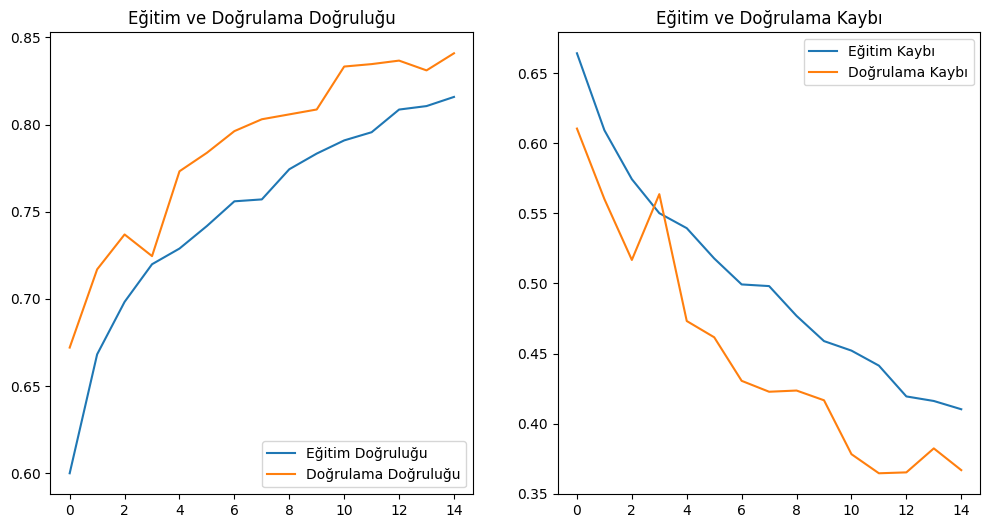

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

         Cat       0.51      0.43      0.47      2548
         Dog       0.49      0.57      0.53      2452

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000


Karmaşıklık Matrisi:


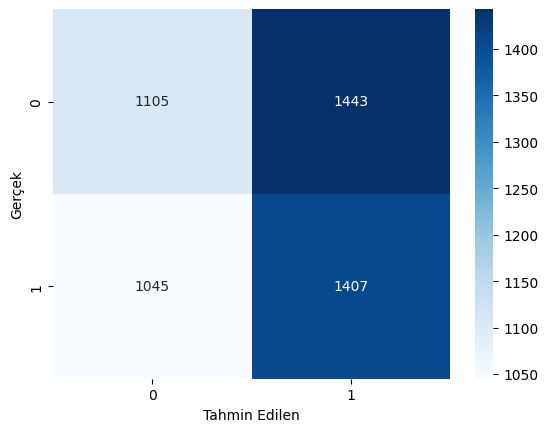

In [5]:
# Eğitim ve Doğrulama Doğruluk/Kayıp grafiklerini çizdirme
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

# Karmaşıklık Matrisi (Confusion Matrix) ve Sınıflandırma Raporu
# Modelin doğrulama seti üzerindeki tahminlerini alalım
predictions = model.predict(validation_generator)
# Sigmoid çıktısını (0-1 arası olasılık) 0 veya 1 sınıfına dönüştürelim
predicted_classes = np.where(predictions > 0.5, 1, 0) 
true_classes = validation_generator.classes

print("\nSınıflandırma Raporu:")
print(classification_report(true_classes, predicted_classes, target_names=['Cat', 'Dog']))

print("\nKarmaşıklık Matrisi:")
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()